# AI Skill Showcase
**Author:** Advitiya Sharma (University of Waterloo, Computer Engineering)
**Interests**
- make aviation projects
- learn and work over artTech and fashionTech
- yoga and pilates

**What this shows**
- Loads two images
- Runs a pretrained CNN (MobileNetV2)
- Generates Grad-CAM heatmaps
- Displays originals vs overlays
- Notes next steps for See-DR


In [1]:
import tensorflow as tf, numpy as np
print("TF:", tf.__version__, "| NumPy:", np.__version__)


TF: 2.19.0 | NumPy: 2.0.2


In [3]:
# Don't install TensorFlow. Keep the built-in 2.19.x.
# We only add helper libs and avoid pulling extra deps.
%pip -q install --no-deps opencv-python matplotlib requests

import tensorflow as tf, numpy as np, cv2, matplotlib.pyplot as plt, requests
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import decode_predictions

print("TF:", tf.__version__, "| NumPy:", np.__version__)


TF: 2.19.0 | NumPy: 2.0.2


In [4]:
# Try downloading two public-domain images. If download is blocked,
# a file picker will ask you to upload two images (any jpg/png) manually.

IMG1_URLS = [
    "https://upload.wikimedia.org/wikipedia/commons/3/37/African_Bush_Elephant.jpg",
]
IMG2_URLS = [
    "https://upload.wikimedia.org/wikipedia/commons/b/bb/Red_squirrel_2009.jpg",
]

def download_to(url, path):
    headers = {"User-Agent": "Mozilla/5.0"}
    r = requests.get(url, headers=headers, stream=True, timeout=30)
    r.raise_for_status()
    with open(path, "wb") as f:
        for chunk in r.iter_content(1024 * 1024):
            if chunk:
                f.write(chunk)

def ensure_two_images():
    p1, p2 = "img1.jpg", "img2.jpg"
    ok1 = ok2 = False
    # try downloads
    for u in IMG1_URLS:
        try: download_to(u, p1); ok1 = True; break
        except Exception as e: print(f"[img1] failed {u}: {e}")
    for u in IMG2_URLS:
        try: download_to(u, p2); ok2 = True; break
        except Exception as e: print(f"[img2] failed {u}: {e}")

    if ok1 and ok2:
        return p1, p2

    # fallback: manual upload
    try:
        from google.colab import files
        print("Auto-download failed. Please upload two images (any .jpg/.png).")
        uploaded = files.upload()  # UI opens
        names = list(uploaded.keys())
        assert len(names) >= 2, "Please upload at least two images."
        # Save first two as img1.jpg/img2.jpg
        open("img1.jpg","wb").write(uploaded[names[0]])
        open("img2.jpg","wb").write(uploaded[names[1]])
        return "img1.jpg", "img2.jpg"
    except Exception as e:
        raise RuntimeError("Could not obtain two images via download or upload.") from e

def load_for_model(path, target=(224,224)):
    img = load_img(path, target_size=target)       # PIL image
    x = img_to_array(img)                           # (224,224,3)
    vis = np.array(img).astype(np.uint8)           # keep copy for plotting
    x = np.expand_dims(x, 0)                       # (1,224,224,3)
    x = mobilenet_v2.preprocess_input(x)           # MobileNetV2 normalization
    return x, vis

p1, p2 = ensure_two_images()
x1, vis1 = load_for_model(p1)
x2, vis2 = load_for_model(p2)
print("Ready with:", p1, p2, "| shapes:", x1.shape, x2.shape)


[img2] failed https://upload.wikimedia.org/wikipedia/commons/b/bb/Red_squirrel_2009.jpg: 404 Client Error: Not Found for url: https://upload.wikimedia.org/wikipedia/commons/b/bb/Red_squirrel_2009.jpg
Auto-download failed. Please upload two images (any .jpg/.png).


Saving Screenshot 2025-09-17 190805.png to Screenshot 2025-09-17 190805.png
Saving Screenshot 2025-09-17 190944.png to Screenshot 2025-09-17 190944.png
Ready with: img1.jpg img2.jpg | shapes: (1, 224, 224, 3) (1, 224, 224, 3)


In [5]:
# Load pretrained ImageNet model
model = mobilenet_v2.MobileNetV2(weights="imagenet")

# Auto-detect the last Conv2D layer (robust across Keras versions)
last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break
print("Last conv layer:", last_conv_layer_name)

# Predict top-1 for both images
preds1 = model.predict(x1, verbose=0)
preds2 = model.predict(x2, verbose=0)
print("Image 1 top-1:", decode_predictions(preds1, top=1)[0][0])
print("Image 2 top-1:", decode_predictions(preds2, top=1)[0][0])


14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Last conv layer: Conv_1
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Image 1 top-1: ('n02504458', 'African_elephant', np.float32(0.72919077))
Image 2 top-1: ('n02356798', 'fox_squirrel', np.float32(0.3517247))


In [7]:
def grad_cam(img_batch, model, last_conv_layer_name):
    # Model that returns last conv outputs + final predictions
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_batch)
        class_idx = tf.argmax(preds[0])                 # target: top-1 class
        loss = preds[:, class_idx]

    grads = tape.gradient(loss, conv_out)               # dScore/dFeatureMap
    weights = tf.reduce_mean(grads, axis=(0,1,2))       # channel importance
    conv_out = conv_out[0]
    cam = tf.reduce_sum(weights * conv_out, axis=-1)    # weighted sum
    cam = tf.nn.relu(cam)
    cam = cam / (tf.reduce_max(cam) + 1e-8)             # normalize [0,1]
    return cam.numpy(), int(class_idx.numpy())

def overlay_heatmap(img_rgb_uint8, heatmap, alpha=0.35):
    # Convert original to BGR to match OpenCV's heatmap, overlay, then back to RGB
    img_bgr = cv2.cvtColor(img_rgb_uint8, cv2.COLOR_RGB2BGR)
    h = cv2.resize(heatmap, (img_rgb_uint8.shape[1], img_rgb_uint8.shape[0]))
    h = np.uint8(255 * h)
    h = cv2.applyColorMap(h, cv2.COLORMAP_JET)          # BGR
    out_bgr = cv2.addWeighted(h, alpha, img_bgr, 1-alpha, 0)
    out_rgb = cv2.cvtColor(out_bgr, cv2.COLOR_BGR2RGB)
    return out_rgb


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


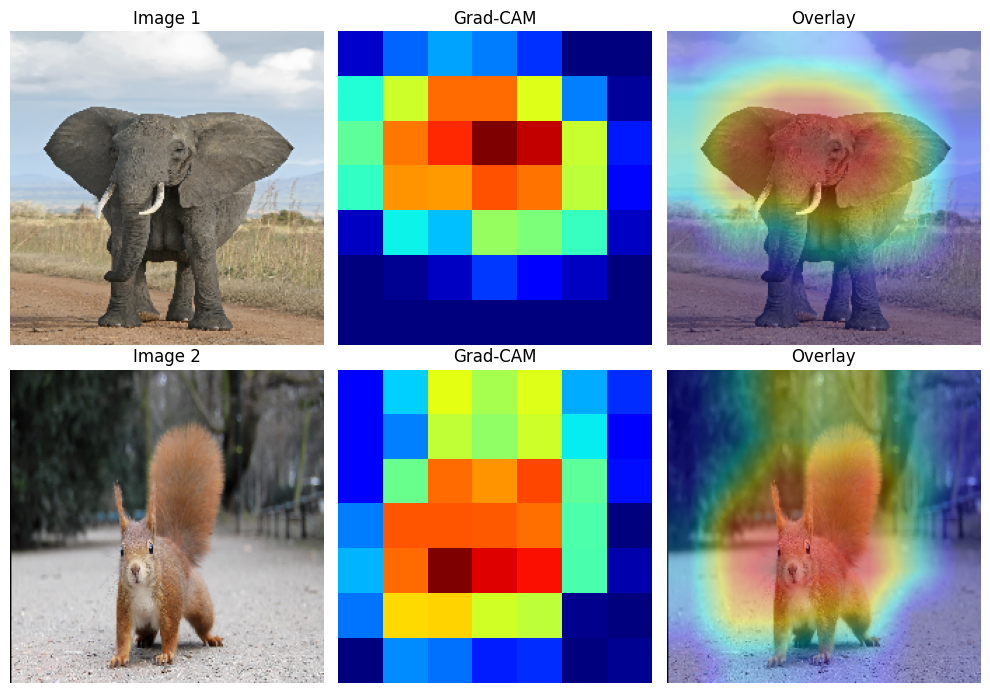

In [8]:
hm1, _ = grad_cam(x1, model, last_conv_layer_name)
hm2, _ = grad_cam(x2, model, last_conv_layer_name)

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
axes[0,0].imshow(vis1); axes[0,0].set_title("Image 1"); axes[0,0].axis("off")
axes[0,1].imshow(hm1, cmap="jet"); axes[0,1].set_title("Grad-CAM"); axes[0,1].axis("off")
axes[0,2].imshow(overlay_heatmap(vis1, hm1)); axes[0,2].set_title("Overlay"); axes[0,2].axis("off")

axes[1,0].imshow(vis2); axes[1,0].set_title("Image 2"); axes[1,0].axis("off")
axes[1,1].imshow(hm2, cmap="jet"); axes[1,1].set_title("Grad-CAM"); axes[1,1].axis("off")
axes[1,2].imshow(overlay_heatmap(vis2, hm2)); axes[1,2].set_title("Overlay"); axes[1,2].axis("off")

plt.tight_layout(); plt.show()


In [9]:
def blur_score(img_rgb_uint8):
    gray = cv2.cvtColor(img_rgb_uint8, cv2.COLOR_RGB2GRAY)
    return float(cv2.Laplacian(gray, cv2.CV_64F).var())

print("Image 1 blur score (higher ≈ sharper):", round(blur_score(vis1), 2))
print("Image 2 blur score (higher ≈ sharper):", round(blur_score(vis2), 2))


Image 1 blur score (higher ≈ sharper): 1882.82
Image 2 blur score (higher ≈ sharper): 1911.91


## Notes & Next Steps
- **What Grad-CAM is:** It highlights regions that most influenced the model’s top prediction.
- **Limitations:** This uses a general ImageNet model; saliency ≠ medical diagnosis.
- **For See-DR:** Train on retinal datasets (DR labels), export to TensorFlow Lite / ONNX Runtime Mobile, add on-device image-quality checks (blur/illumination), and show heatmaps in the mobile UI for transparency.
